# Using Machine Learning to determine factors that distinguish different job titles.

___

This is a continuation from Part 1, where I studied factors that affect the salary range of data related jobs. Prior to this, I web scraped real data from Singapore's MyCareersFuture website for job listings of data related positions. Thereafter, I also cleaned the data while performing exploratory data analysis. 

You can refer to the other notebooks, titled 'Web Scrapping - Using Selenium and Beautiful Soup' and 'Part 1 - Studying Factors that Affect Salaries'.

In this notebook, I will continue to perform more exploratory data analysis and build machine learning models to determine the factors that distinguish the different job titles.

### Key goal for this project:

Explore relationship and determine the factors that distinguish types of job titles from each other.

### Contents for this notebook:

1. Detailed steps & codes used, with explanation of each step
2. Executive Summary of findings at the end of the notebook

### Steps that I will be taking for this portion of the project:

1. Exploratory Data Analysis
 - Identify relationship between factors and identify those that may affect different job titles
 - Using Natural Language Processing (NLP) techniques for text data
3. Build a classification model for the prediction after resampling classes
 - Logistic Regression
 - K-Nearest Neighbors Classifier
 - Random Forest Classifier
4. Intepret the results of the models to refine the models
5. Summarize my findings and identify limitations

<font color='purple'>

# Detailed steps & codes used

____

</font>

### Import required packages

In [1]:
# Import basic packages for visualization

import pandas as pd
from pandas import DataFrame 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import all required packages for machine learning

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

### Load CSV file with cleaned data

In [74]:
# Load the csv file with data that was cleaned in the notebook - 'Part 1 - Studying Factors that Affect Salaries'
    
file = './CleanedJobsData.csv'
mcsg = pd.read_csv(file, index_col=0)

In [75]:
# Check the shape of the dataframe

mcsg.shape

(1041, 47)

In [76]:
# Open dataframe to check columns

mcsg.head(2)

,job_id,job_desc,job_req,comp,address,sal_amt_min,sal_amt_max,sal_mid,sal_range,emp_type_clean,...,Manufacturing,Building and Construction,Design,Repair and Maintenance,Marketing / Public Relations,Travel / Tourism,Human Resources,Legal,Events / Promotions,General Work
0,JOB-2019-0019774,Sky Premium International is looking for IT Ex...,Requirements & Pre-Requisite : - Minimum a Deg...,SKY PREMIUM INTERNATIONAL PTE. LTD.,"ONE RAFFLES PLACE, 1 RAFFLES PLACE 048616",2500.0,4000.0,3250.0,0.0,Permanent,...,0,0,0,0,0,0,0,0,0,0
1,JOB-2019-0091291,•Frontline team members who have to mix solid ...,•Frontline team members who have to mix solid ...,CAPGEMINI SINGAPORE PTE. LTD.,6 BATTERY ROAD 049909,5000.0,7500.0,6250.0,0.0,Permanent,...,0,0,0,0,0,0,0,0,0,0


__Explanation of the information available:__

    * job_id: Job listing ID
    * job_title_clean: Job title 
    * job_desc: Description of the job
    * job_req: Requirements for the job
    * yrs_exp: Level of the job eg. Entry level / Professional
    * comp: Name of company advertising for the job
    * address: Address of the company
    * sal_amt_min: Lowest amount of salary range for the job
    * sal_amt_max: Highest amount of salary range for the job
    * sal_mid: Average of salary range for the job
    * sal_range: Salary range for the job
    * emp_type_clean: Employment type e.g. Full-Time, Part-Time, Permanent, Contract
    * List of job seniorities e.g. Professional, Executive, Manager, Fresh/entry level, Non-executive
    * List of industries e.g. Manufacturing: Job industry

In [77]:
# Take a look at the dataframe header
mcsg.columns

Index(['job_id', 'job_desc', 'job_req', 'comp', 'address', 'sal_amt_min',
       'sal_amt_max', 'sal_mid', 'sal_range', 'emp_type_clean', 'Professional',
       'Executive', 'Manager', 'Fresh/entry level', 'Non-executive',
       'job_title_clean', 'Information Technology', 'Engineering',
       'Admin / Secretarial', 'Banking and Finance', 'Public / Civil Service',
       'Advertising / Media ', 'Consulting ',
       'Accounting / Auditing / Taxation', 'Logistics / Supply Chain',
       'Others', 'Insurance', 'General Management',
       'Sciences / Laboratory / R&D', 'Professional Services',
       'Sales / Retail ', 'Customer Service', 'Education and Training',
       'Telecommunications', 'Risk Management', 'Environment / Health  ',
       'Healthcare / Pharmaceutical', 'Manufacturing',
       'Building and Construction', 'Design', 'Repair and Maintenance',
       'Marketing / Public Relations ', 'Travel / Tourism', 'Human Resources ',
       'Legal', 'Events / Promotions ', 'Gener

In [78]:
# Drop some features that I will not be studying, to get the final dataframe.

df = mcsg.drop(['job_id', 'comp', 'address', 'sal_amt_min','sal_amt_max'], axis=1)

## Exploratory Data Analysis

### Study if there is any difference in salary ranges / average salary amount for different job titles

In [8]:
# Consolidate list of job titles for use in the later part of the notebook

title_list = ['data scientist', 'data/business analyst', 'data architect/engineer', 'academics', 
              'management', 'others']

In [9]:
# Consolidate list of seniority types for use in the later part of the notebook

seniority_type = ['Professional','Executive','Manager','Fresh/entry level','Non-executive']

In [10]:
# Consolidate list of industries for use in the later part of the notebook

indus_list = ['Information Technology', 'Engineering', 'Admin / Secretarial', 'Banking and Finance', 
              'Public / Civil Service', 'Advertising / Media ', 'Consulting ', 'Accounting / Auditing / Taxation', 
              'Logistics / Supply Chain', 'Others', 'Insurance', 'General Management', 
              'Sciences / Laboratory / R&D', 'Professional Services', 'Sales / Retail ', 'Customer Service', 
              'Education and Training', 'Telecommunications', 'Risk Management', 'Environment / Health  ', 
              'Healthcare / Pharmaceutical', 'Manufacturing', 'Building and Construction', 'Design', 
              'Repair and Maintenance', 'Marketing / Public Relations ', 'Travel / Tourism', 'Human Resources ', 
              'Legal', 'Events / Promotions ', 'General Work']

In [11]:
# Check relationship between job titles and salary range

print('Proportion of Job Listings in the High Paying Salary Range')
print('----------------')

for title in title_list:
    print(title,' -- ',df[df['job_title_clean'] == title]['sal_range'].mean())

Proportion of Job Listings in the High Paying Salary Range
----------------
data scientist  --  0.4423076923076923
data/business analyst  --  0.36363636363636365
data architect/engineer  --  0.43
academics  --  0.0958904109589041
management  --  0.7380952380952381
others  --  0.43312101910828027


In [12]:
# Chekc relationship between job titles and average salary amount

print('Average Salary for different Job Listings')
print('----------------')

for title in title_list:
    print(title,' -- ',df[df['job_title_clean'] == title]['sal_mid'].mean())

Average Salary for different Job Listings
----------------
data scientist  --  7711.891025641025
data/business analyst  --  6826.180840664712
data architect/engineer  --  7370.725000000001
academics  --  5292.260273972603
management  --  9807.785714285714
others  --  7029.644373673035


From the information above, there is a difference in proportion of job listings in the average salary / salary ranges for different titles. As both features relate to salaries, I will pick only 1 feature to use in my model. 

I will choose to use average salary instead of salary range, as salary range is a feature that I created myself through classifying the salaries into 2 ranges and may not be as accurate as the average salary feature.

### Study if there is any difference in proportion of seniority level for different job titles

In [13]:
# Check relationship between seniority level and job titles

for title in title_list:
    print('Proportion of Seniority Level for',title)
    print('----------------')
    
    for seniority in seniority_type:
        print(seniority,' -- ',df[df['job_title_clean'] == title][seniority].mean())
        
    print('--------------------------------------------------------------')

Proportion of Seniority Level for data scientist
----------------
Professional  --  0.39090909090909093
Executive  --  0.36363636363636365
Manager  --  0.21818181818181817
Fresh/entry level  --  0.07272727272727272
Non-executive  --  0.05454545454545454
--------------------------------------------------------------
Proportion of Seniority Level for data/business analyst
----------------
Professional  --  0.3074866310160428
Executive  --  0.4946524064171123
Manager  --  0.18181818181818182
Fresh/entry level  --  0.03208556149732621
Non-executive  --  0.03208556149732621
--------------------------------------------------------------
Proportion of Seniority Level for data architect/engineer
----------------
Professional  --  0.40654205607476634
Executive  --  0.3925233644859813
Manager  --  0.21962616822429906
Fresh/entry level  --  0.028037383177570093
Non-executive  --  0.028037383177570093
--------------------------------------------------------------
Proportion of Seniority Level for 

From the information above, the difference in proportion of seniority levels is relatively minimal for the different job titles. Hence, I will not choose to use this feature to predict job titles. 

## Study if there is any difference in proportion of employment types for different job titles

In [14]:
# Check relationship between employment types and job titles

print('Proportion of Employment Types in different job listings')
print('----------------')

for title in title_list:
    print(title,' -- ')
    print(df[df['job_title_clean'] == title]['emp_type_clean'].value_counts())
    print('')

Proportion of Employment Types in different job listings
----------------
data scientist  -- 
Permanent     81
Contract      28
Internship     1
Name: emp_type_clean, dtype: int64

data/business analyst  -- 
Permanent     289
Contract       84
Internship      1
Name: emp_type_clean, dtype: int64

data architect/engineer  -- 
Permanent     172
Contract       40
Internship      2
Name: emp_type_clean, dtype: int64

academics  -- 
Contract     57
Permanent    20
Name: emp_type_clean, dtype: int64

management  -- 
Permanent    94
Contract      6
Name: emp_type_clean, dtype: int64

others  -- 
Permanent     137
Contract       27
Internship      2
Name: emp_type_clean, dtype: int64



In [15]:
# Create a nested dictionary
    # With job title as the key
    # Proportion of employment types for the job title as the value

emp_type_dict = {}

for title in title_list:
    job_emp_type = df[df['job_title_clean'] == title]['emp_type_clean'].value_counts().index
    job_emp_type_count = df[df['job_title_clean'] == title]['emp_type_clean'].value_counts().values
    
    job_emp_type_dict = {}
    
    for i,job in enumerate(job_emp_type):
        job_emp_type_dict[job] = job_emp_type_count[i]/np.sum(job_emp_type_count)*100
    
    emp_type_dict[title] = job_emp_type_dict

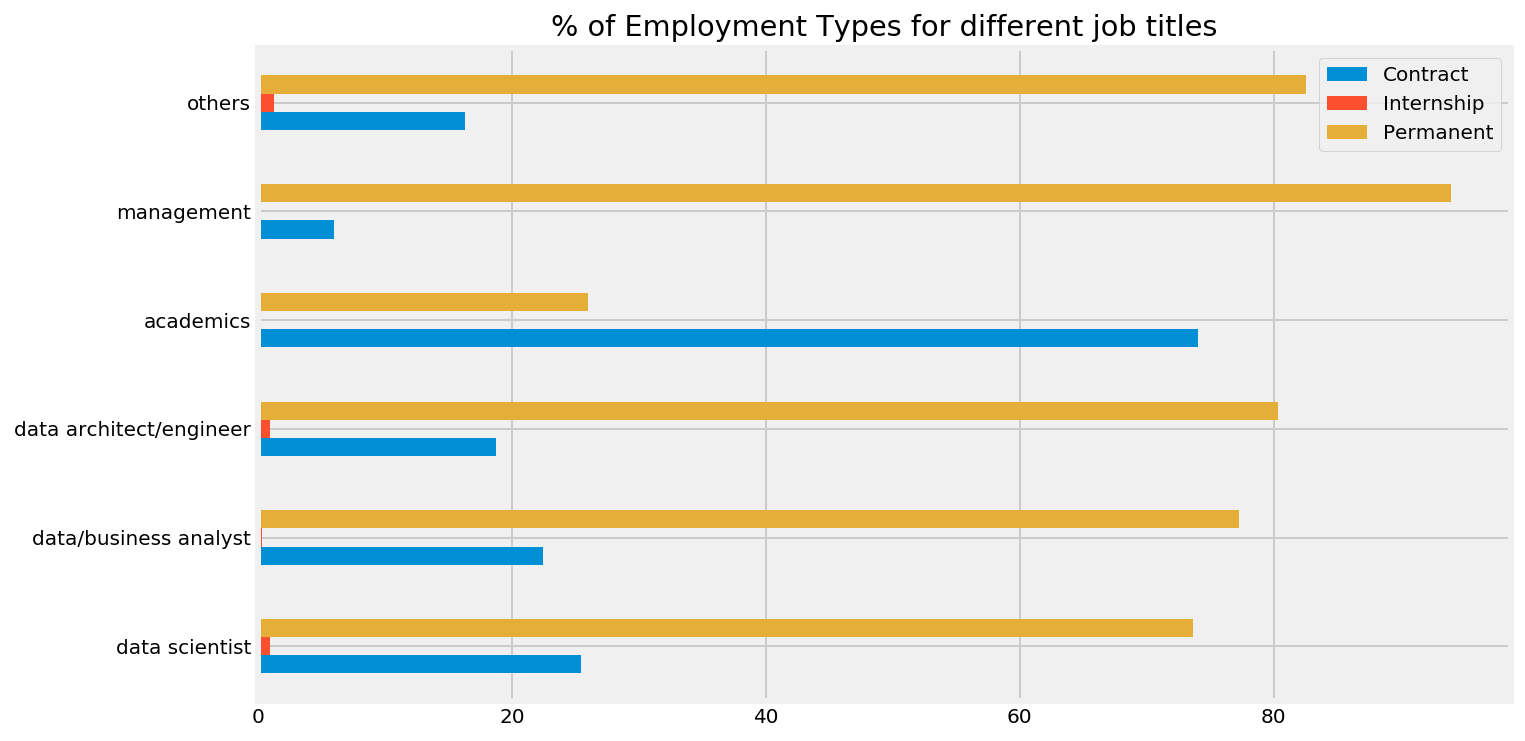

In [16]:
# Create a DataFrame with the nested dictionary
# Plot bar chart with the nested dictionary, to visualize the % of different employment types
# for the various job titles

pd.DataFrame(emp_type_dict).T.plot(kind='barh', figsize = (10,6))
plt.title('% of Employment Types for different job titles');

From the plot above, most of the jobs have a similar make-up of Permanent, Contract and Internship positions, except the academics, which look very different. For the academics, the proportion of Contract positions is much higher than Permanent positions, unlike the other jobs.

### Hypothesis Testing

To determine whether to use employment type as a feature, I will conduct a chi-square test to see if there is the categorical difference is statistically significant.

In [17]:
# Creating dataframe with counts of different employment types for different job titles 
    # (instead of % of different employment types, that was created and visualized above)
# I will use this dataframe as the contingency table for my chi square test

    # Create a dictionary of job titles and counts of employment types
emp_type_dict = {}

for title in title_list:
    job_emp_type = df[df['job_title_clean'] == title]['emp_type_clean'].value_counts().index
    job_emp_type_count = df[df['job_title_clean'] == title]['emp_type_clean'].value_counts().values
    
    job_emp_type_dict = {}
    
    for i,job in enumerate(job_emp_type):
        job_emp_type_dict[job] = job_emp_type_count[i]
    
    emp_type_dict[title] = job_emp_type_dict

    # Convert this to a series
chi_contin = pd.DataFrame(emp_type_dict).T

    # Replace nan values with 0 since the nan values in this case are actually 0 
    # (No internship positions, hence pandas filled the value as nan when creating dataframe earlier)
chi_contin = chi_contin.fillna(0)

In [18]:
# Conduct a chi square test 

import scipy.stats as stats

contin = pd.DataFrame(chi_contin)
chi2, p, dof, ex = stats.chi2_contingency(contin)
print('The p-value is',p)

The p-value is 8.306833588438395e-25


As the p-value is less than 0.05, I will can go ahead to reject the null hypothesis and conclude that the job titles are categorically different statistically. Hence, I will use the employment types as a feature for my prediction model. 

###  Study if there is any difference in proportion of industries for different job titles

In [19]:
# Check relationship between proportion of industries and job titles

for title in title_list:
    print('          ')
    print('Proportion of Industries for',title)
    print('----------------')
    
    for indus in indus_list:
        if df[df['job_title_clean'] == title][indus].mean() > 0.05:
            print(indus,' -- ',df[df['job_title_clean'] == title][indus].mean())
        
    print('--------------------------------------------------------------')

          
Proportion of Industries for data scientist
----------------
Information Technology  --  0.5818181818181818
Engineering  --  0.14545454545454545
Banking and Finance  --  0.07272727272727272
Sciences / Laboratory / R&D  --  0.14545454545454545
--------------------------------------------------------------
          
Proportion of Industries for data/business analyst
----------------
Information Technology  --  0.6256684491978609
Banking and Finance  --  0.23529411764705882
Public / Civil Service  --  0.053475935828877004
Consulting   --  0.05080213903743316
Others  --  0.06149732620320856
--------------------------------------------------------------
          
Proportion of Industries for data architect/engineer
----------------
Information Technology  --  0.6728971962616822
Engineering  --  0.20093457943925233
Banking and Finance  --  0.07009345794392523
Public / Civil Service  --  0.06542056074766354
Sciences / Laboratory / R&D  --  0.08411214953271028
--------------------

From the information above, it seems like the top industries for all of the different job titles are relatively similar, i.e. Information Technology, Engineering, Banking and Finance, Public /Civil Service. 

Hence, I will not use the industries as a feature.

## Split data into train and test set

<br>

All columns except Job Description and Job Requirements have been processed and explored. As these 2 columns contain texts, the most effective way to study the data in these columns would be using Natural Language Processing (NLP) techniques e.g. CountVectorizer. 

The reason I am using CountVectorizer for this is because I would like to do a simple tokenization and count. I did not do Term Frequency-Inverse Document Frequency Vectorizer (TF-IDF) because I expect many common phrases and terms used for the data science context will be frequently repeated. Hence, I will stick to CountVectorizer to prevent these signals from being removed when using TF-IDF.

Before I start doing that, I will split the dataset into train and test set first. This is because the best practice for using the CountVectorizer technique requires training separately only on the train data, before using the same parameters to transform the test data. 

_____

I will build a classification model to predict job title. 

__Target variable:__
* Job Titles
    

__Possible prediction variables:__
* Average Salary
* Job Description and Requirements

____

In [79]:
# Drop features that I have decided that I will not be using after doing EDA

df = df.drop(['sal_range','Professional','Executive','Manager','Fresh/entry level','Non-executive',
              'Information Technology','Engineering','Admin / Secretarial','Banking and Finance',
              'Public / Civil Service','Advertising / Media ','Consulting ','Accounting / Auditing / Taxation',
              'Logistics / Supply Chain','Others','Insurance','General Management','Sciences / Laboratory / R&D',
              'Professional Services','Sales / Retail ','Customer Service','Education and Training',
              'Telecommunications','Risk Management','Environment / Health  ','Healthcare / Pharmaceutical',
              'Manufacturing','Building and Construction','Design','Repair and Maintenance',
              'Marketing / Public Relations ','Travel / Tourism','Human Resources ','Legal','Events / Promotions ',
              'General Work'], axis=1)

In [80]:
# Check the number of null values in the dataframe
df.isnull().sum()

job_desc            0
job_req            67
sal_mid            82
emp_type_clean      0
job_title_clean     0
dtype: int64

In [81]:
# Drop the null values in the average salary column 
    # I will not impute the average salary data 
    # as I had tried to predict salary amount but was not able to get a good result

df = df[~df['sal_mid'].isnull()]

In [82]:
# Set up the predictor and target variables

X = df.drop('job_title_clean', axis=1)
y = df['job_title_clean']

In [83]:
# Set up the train and test set, stratifying based on the labels in y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=1)

In [84]:
# I will standardize the features after doing CountVectorization

### Use NLP techniques to study the job requirements and job description columns

Use CountVectorizer for feature extraction in job description and job requirements column to extract the most important words found in the all job listings. 

In addition, I will combine job description and job requirements together as there is likely repetitive information in these 2 columns, since both columns detail the factors important for a job listing.

#### First, combine job description and job requirements columns and stem the text

In [85]:
# Create a function to combine job description and job requirements together
    # So we can use this function on both the train and test set

def combine_text(df, col1, col2):
    # df is the dataframe we are working with
    # col1 and col2 are the name of the columns to be combined together
    # returns the combined text
    
    text = []

    for index_desc, desc in enumerate(df[col1].values):
        try:
            text.append(desc+df[col2].values[index_desc])
        except TypeError:
            text.append(desc)
        
    return text

In [86]:
# Create a function to use SnowballStemmer to do stemming of words in all the text
    # So we can use this function on both the train and test set

def stem_text(combined_text,df,col3):
    # combined_text is the output from the function combine_text
    # df is the dataframe we are working with
    # col3 is the name of the new column that the stemmed text will be added to
    
    stemmer = SnowballStemmer("english")
    stemmed_text = []

    for job in combined_text:
        job = stemmer.stem(job)
        stemmed_text.append(job)
    
    df[col3] = stemmed_text
    return df

In [87]:
# Apply the functions on both the train and test set

X_train = stem_text(combine_text(X_train,'job_desc','job_req'),X_train,'job_desc_req')
X_test = stem_text(combine_text(X_test,'job_desc','job_req'),X_test,'job_desc_req')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Next, start using CountVectorizer on the text

In [29]:
# Fit CountVectorizer to tokenize the data
   # I played around with some of the parameters e.g. min_df and ngram_range. The hyperparameters used below 
   # are the most optimal ones that I had tried

# The top results consists of some irrelvant words that do not tell much, e.g. requirements, work, shortlisted, candidates
# Hence, I will add those words to stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)

stop = ['requirements','work','candidates','shortlisted','end','regret','notified','analyst','scientist']

for word in stop:
    stopwords.append(word)

cvt = CountVectorizer(min_df=0.05, ngram_range=(2,4), stop_words=stopwords)
cvt.fit(X_train['job_desc_req'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngram_range=(2, 4), preprocessor=None,
        stop_words=['rather', 'which', 'around', 'fifteen', 'though', 'were', 'thereupon', 'whom', 'have', 'five', 'being', 'enough', 'ours', 'third', 'within', 'interest', 'among', 'back', 'seem', 'with', 'another', 'put', 'into', 'whereas', 'but', 'am', 'him', 'somewhere', 'cant', 'three', 'was', 'can', '...irements', 'work', 'candidates', 'shortlisted', 'end', 'regret', 'notified', 'analyst', 'scientist'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
# Perform the transformation on X_train

job_desc_req_words = cvt.transform(X_train['job_desc_req'])
columns = np.array(cvt.get_feature_names())

In [31]:
# Join the token count info back to the main DataFrame for X_train

    # Create separate Dataframe for CountVectorized info first
cvt_job = pd.DataFrame(job_desc_req_words.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_train.reset_index(drop = True, inplace = True) 
X_train = pd.concat([X_train,cvt_job],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_train = X_train.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [32]:
# Function to get the most frequent words

def get_freq_words(sparse_counts, columns):
    word_counts = np.asarray(sparse_counts.sum(axis=0)).reshape(-1)

    largest_count_indices = word_counts.argsort()[::-1]
    freq_words = pd.Series(word_counts[largest_count_indices], 
                            index=columns[largest_count_indices])

    return freq_words

In [33]:
# Get the list of tokens extracted through CountVectorization

words_list = list(get_freq_words(job_desc_req_words,columns).index)

# Get the list of job titles

title_list = ['data scientist', 'data/business analyst', 'data architect/engineer', 'academics', 'management', 'others']

In [34]:
# For the case of this study, I will concatenate X_train and y_train together, together with the token counts,
# in order to study if the key words for different job titles

y_train.reset_index(drop = True, inplace = True) 
study = pd.concat([X_train,y_train], axis=1)

In [35]:
# Create a dictionary of job titles and their key words
    # To convert into a dataframe for easy manipulation later

title_word_scores = {}

for title in title_list:
    word_scores = []
    
    for keyword in words_list:
        word_scores.append(study[study['job_title_clean'] == title][keyword].sum())

    title_word_scores[title] = word_scores
    
# Convert dictionary into dataframe for easy manipulation 
study_words = pd.DataFrame(title_word_scores, index=words_list)

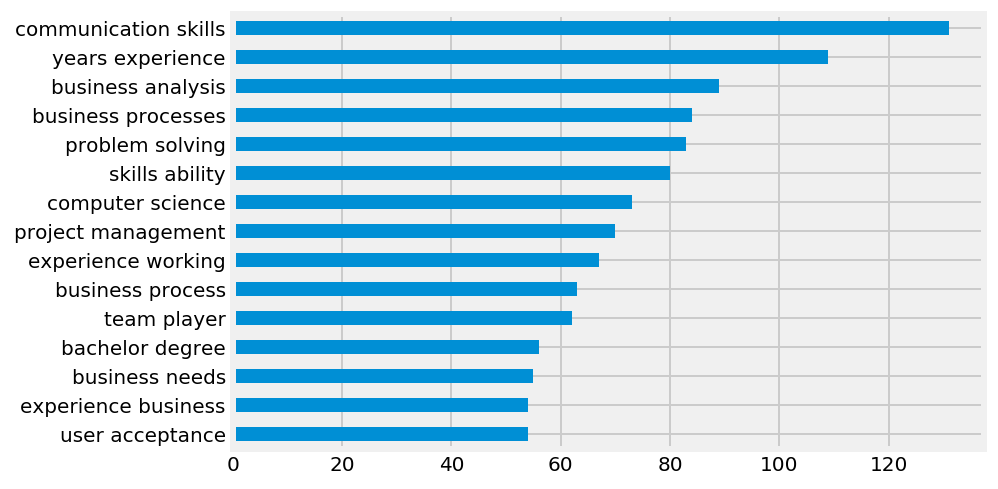

In [36]:
# Find proportion of key words for data/business analyst

study_words['data/business analyst'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [37]:
# Add all the top 15 tokens into a list, to be used as features for classification

key_phrases = []
key_phrases = [phrase for phrase in study_words['data/business analyst'].sort_values(ascending=False)[:15].index]

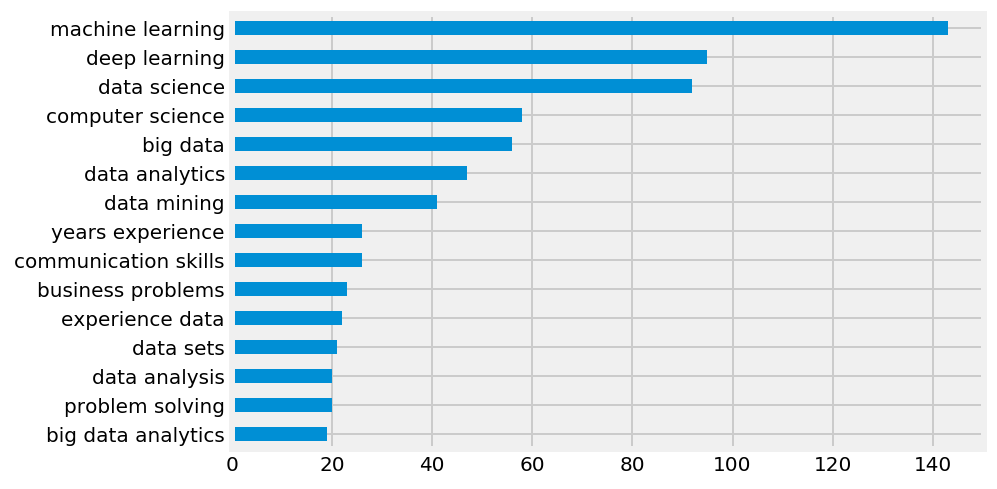

In [38]:
# Find proportion of key words for data scientist

study_words['data scientist'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [39]:
# Add all the top 15 tokens into a list, to be used as features for classification

for phrase in study_words['data scientist'].sort_values(ascending=False)[:15].index:
    if phrase not in key_phrases:
        key_phrases.append(phrase)

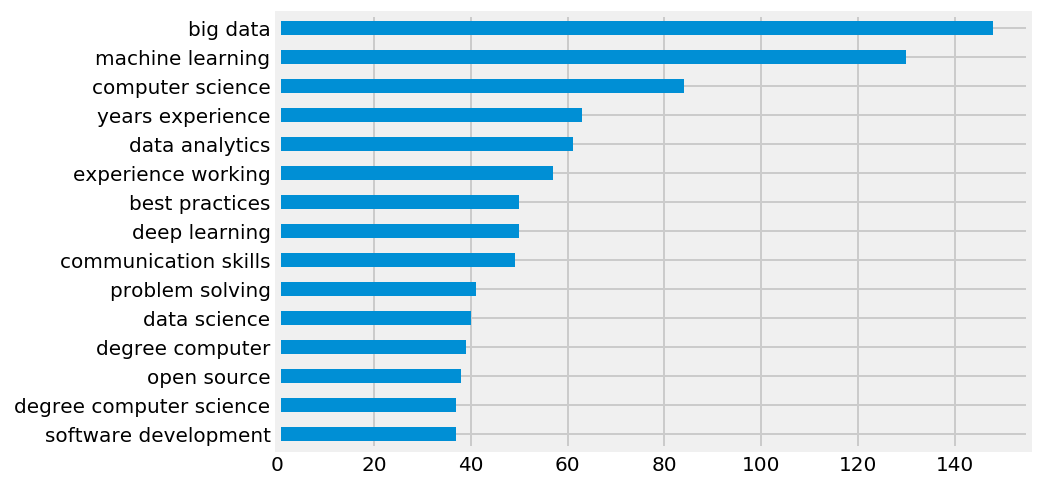

In [40]:
# Find proportion of key words for data architect/engineer

study_words['data architect/engineer'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [41]:
# Add all the top 15 tokens into a list, to be used as features for classification

for phrase in study_words['data architect/engineer'].sort_values(ascending=False)[:15].index:
    if phrase not in key_phrases:
        key_phrases.append(phrase)

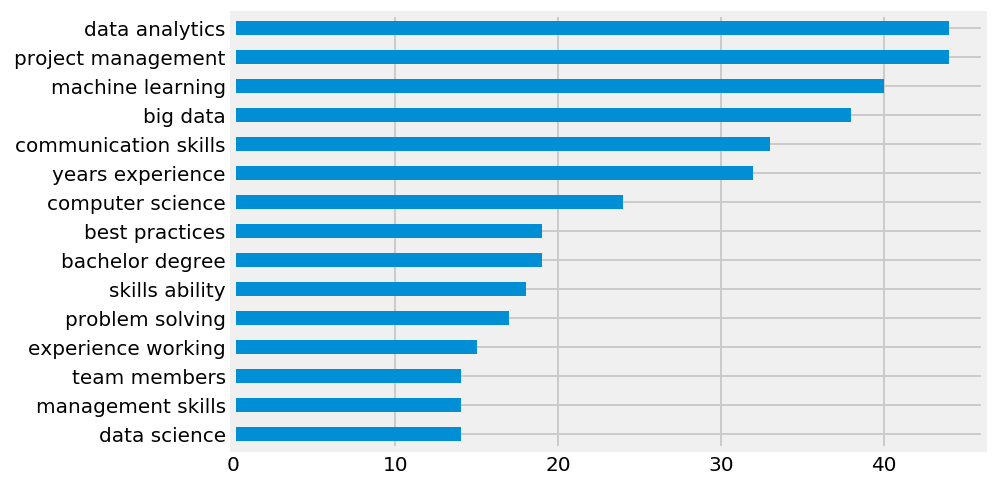

In [42]:
study_words['management'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [43]:
# Add all the top 15 tokens into a list, to be used as features for classification

for phrase in study_words['management'].sort_values(ascending=False)[:15].index:
    if phrase not in key_phrases:
        key_phrases.append(phrase)

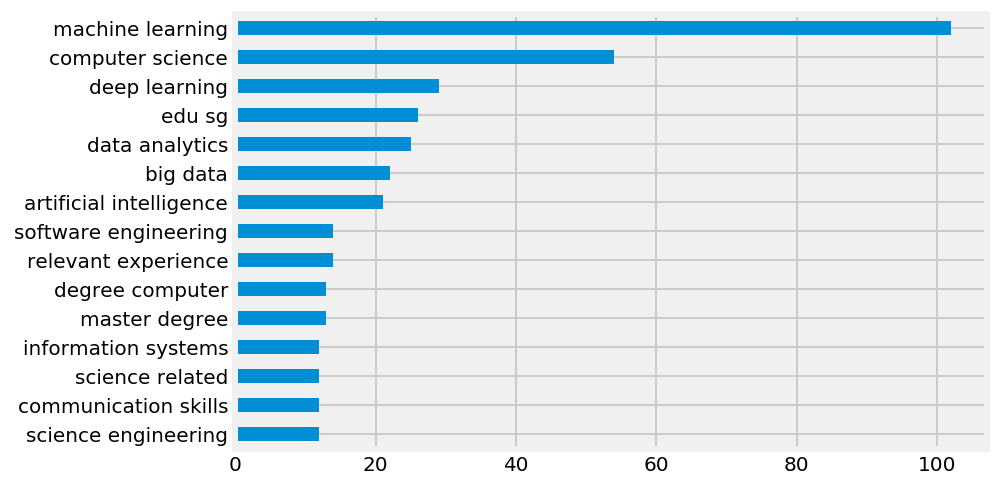

In [44]:
study_words['academics'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [45]:
# Add all the top 15 tokens into a list, to be used as features for classification

for phrase in study_words['academics'].sort_values(ascending=False)[:15].index:
    if phrase not in key_phrases:
        key_phrases.append(phrase)

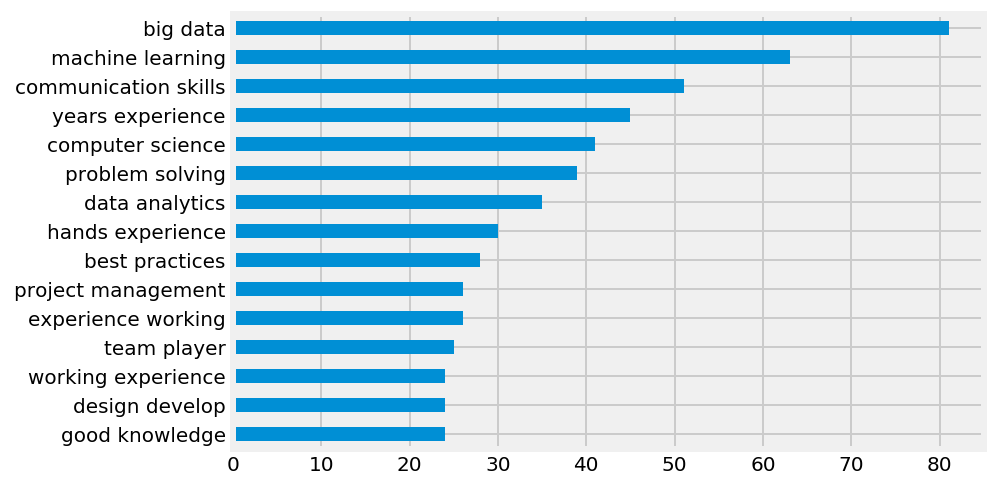

In [46]:
study_words['others'].sort_values(ascending=False)[:15].sort_values(ascending=True).plot(kind='barh');

In [47]:
# Add all the top 15 tokens into a list, to be used as features for classification

for phrase in study_words['others'].sort_values(ascending=False)[:15].index:
    if phrase not in key_phrases:
        key_phrases.append(phrase)

In [48]:
# Check top key words in the jobs

print(key_phrases)

['communication skills', 'years experience', 'business analysis', 'business processes', 'problem solving', 'skills ability', 'computer science', 'project management', 'experience working', 'business process', 'team player', 'bachelor degree', 'business needs', 'user acceptance', 'experience business', 'machine learning', 'deep learning', 'data science', 'big data', 'data analytics', 'data mining', 'business problems', 'experience data', 'data sets', 'data analysis', 'big data analytics', 'best practices', 'degree computer', 'open source', 'software development', 'degree computer science', 'management skills', 'team members', 'edu sg', 'artificial intelligence', 'relevant experience', 'software engineering', 'master degree', 'science engineering', 'science related', 'information systems', 'hands experience', 'good knowledge', 'design develop', 'working experience']


From the plots above, the top key words for the different job titles are very different. Hence, I will consider using these features for the prediction later.

### Feature Engineering to further study job requirements

From the EDA above, the study seems to be lacking in specific keywords for the technology skills e.g. Python, R etc.

After scouring through more than 25 job listings and referencing to online articles, including an article titled "The Most in Demand Skills for Data Scientist" from Towards Data Science (https://towardsdatascience.com/the-most-in-demand-skills-for-data-scientists-4a4a8db896db), I have come up with a few keywords that should be highly important for data scientists. 

Most important technology skills for Data Scientists / Key words that I will use:
   *  sql
   * hadoop
   * python
   * r
   * spark
   * java
   * sas
   * tableau
   * hive
   * scala
   * c++
   * matlab
   * tensorflow
   * nosql

In [49]:
# Rerun steps above to do CountVectorizer based on my chosen vocabulary

In [64]:
vocab = ['sql','hadoop','python','r','spark','java','sas','hive','scala','c++','matlab','tensorflow',
         'nosql','nlp','master','bachelor']

In [65]:
# Fit CountVectorizer to tokenize the data
   # I played around with some of the parameters e.g. min_df and ngram_range. The hyperparameters used below 
   # are the most optimal ones that I had tried

# The top results consists of some irrelvant words that do not tell much, e.g. requirements, work, shortlisted, candidates
# Hence, I will add those words to stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)

stop = ['requirements','work','candidates','shortlisted','end','regret','notified','analyst','scientist']

for word in stop:
    stopwords.append(word)

cvt = CountVectorizer(min_df=0.05, ngram_range=(1,4), stop_words=stopwords, vocabulary=vocab)
cvt.fit(X_train['job_desc_req'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngram_range=(1, 4), preprocessor=None,
        stop_words=['rather', 'which', 'around', 'fifteen', 'though', 'were', 'thereupon', 'whom', 'have', 'five', 'being', 'enough', 'ours', 'third', 'within', 'interest', 'among', 'back', 'seem', 'with', 'another', 'put', 'into', 'whereas', 'but', 'am', 'him', 'somewhere', 'cant', 'three', 'was', 'can', '...irements', 'work', 'candidates', 'shortlisted', 'end', 'regret', 'notified', 'analyst', 'scientist'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=['sql', 'hadoop', 'python', 'r', 'spark', 'java', 'sas', 'hive', 'scala', 'c++', 'matlab', 'tensorflow', 'nosql', 'nlp', 'master', 'bachelor'])

In [66]:
# Perform the transformation on X_train

job_desc_req_words = cvt.transform(X_train['job_desc_req'])
columns = np.array(cvt.get_feature_names())

In [67]:
# Join the token count info back to the main DataFrame for X_train

    # Create separate Dataframe for CountVectorized info first
cvt_job = pd.DataFrame(job_desc_req_words.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_train.reset_index(drop = True, inplace = True) 
X_train = pd.concat([X_train,cvt_job],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_train = X_train.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [68]:
# For the case of this study, I will concatenate X_train and y_train together, together with the token counts,
# in order to study if the key words for different job titles

y_train.reset_index(drop = True, inplace = True) 
study = pd.concat([X_train,y_train], axis=1)

In [69]:
# Check the mean count of key words / skills for the different job titles
    # To see if the skills that I had shortlisted are important for the data scientist job title

title_list = ['data scientist','data/business analyst','data architect/engineer','academics','management','others']

for title in title_list:
    print('Mean count of Key Words / Skills for ',title)
    print('----------------')
    
    for skill in vocab:
        if study[study['job_title_clean'] == title][skill].mean() > 0.1:
            print(skill,' -- ',study[study['job_title_clean'] == title][skill].mean())
        
    print('--------------------------------------------------------------')

Mean count of Key Words / Skills for  data scientist
----------------
sql  --  0.4772727272727273
hadoop  --  0.2840909090909091
python  --  1.125
spark  --  0.3977272727272727
java  --  0.25
hive  --  0.19318181818181818
scala  --  0.1590909090909091
matlab  --  0.14772727272727273
tensorflow  --  0.25
nosql  --  0.125
nlp  --  0.125
master  --  0.26136363636363635
bachelor  --  0.125
--------------------------------------------------------------
Mean count of Key Words / Skills for  data/business analyst
----------------
sql  --  0.3413793103448276
python  --  0.16551724137931034
master  --  0.12413793103448276
bachelor  --  0.23103448275862068
--------------------------------------------------------------
Mean count of Key Words / Skills for  data architect/engineer
----------------
sql  --  0.6470588235294118
hadoop  --  0.3588235294117647
python  --  0.7235294117647059
spark  --  0.4411764705882353
java  --  0.4294117647058823
hive  --  0.2
scala  --  0.20588235294117646
nosql  --

In [70]:
# Create nested dictionary 
    # With skill as key
    # With the mean of TF-IDF value of each job title as value

skills_dict = {}

for skill in vocab:
    skills_dict[skill] = {}

    for title in title_list:
        skills_dict[skill][title] = study[study['job_title_clean'] == title][skill].mean()

In [71]:
# Create dataframe with the nested dictionary

skills_df = pd.DataFrame(skills_dict)
skills_df

,sql,hadoop,python,r,spark,java,sas,hive,scala,c++,matlab,tensorflow,nosql,nlp,master,bachelor
academics,0.048387,0.000000,0.451613,0.0,0.000000,0.193548,0.016129,0.000000,0.000000,0.0,0.129032,0.048387,0.000000,0.016129,0.306452,0.177419
data architect/engineer,0.647059,0.358824,0.723529,0.0,0.441176,0.429412,0.052941,0.200000,0.205882,0.0,0.035294,0.029412,0.135294,0.064706,0.117647,0.252941
data scientist,0.477273,0.284091,1.125000,0.0,0.397727,0.250000,0.068182,0.193182,0.159091,0.0,0.147727,0.250000,0.125000,0.125000,0.261364,0.125000
data/business analyst,0.341379,0.062069,0.165517,0.0,0.027586,0.068966,0.065517,0.010345,0.003448,0.0,0.031034,0.000000,0.017241,0.003448,0.124138,0.231034
management,0.225352,0.098592,0.225352,0.0,0.169014,0.211268,0.042254,0.126761,0.070423,0.0,0.000000,0.028169,0.014085,0.000000,0.154930,0.295775
others,0.335821,0.223881,0.358209,0.0,0.164179,0.365672,0.067164,0.104478,0.059701,0.0,0.022388,0.029851,0.059701,0.014925,0.104478,0.231343


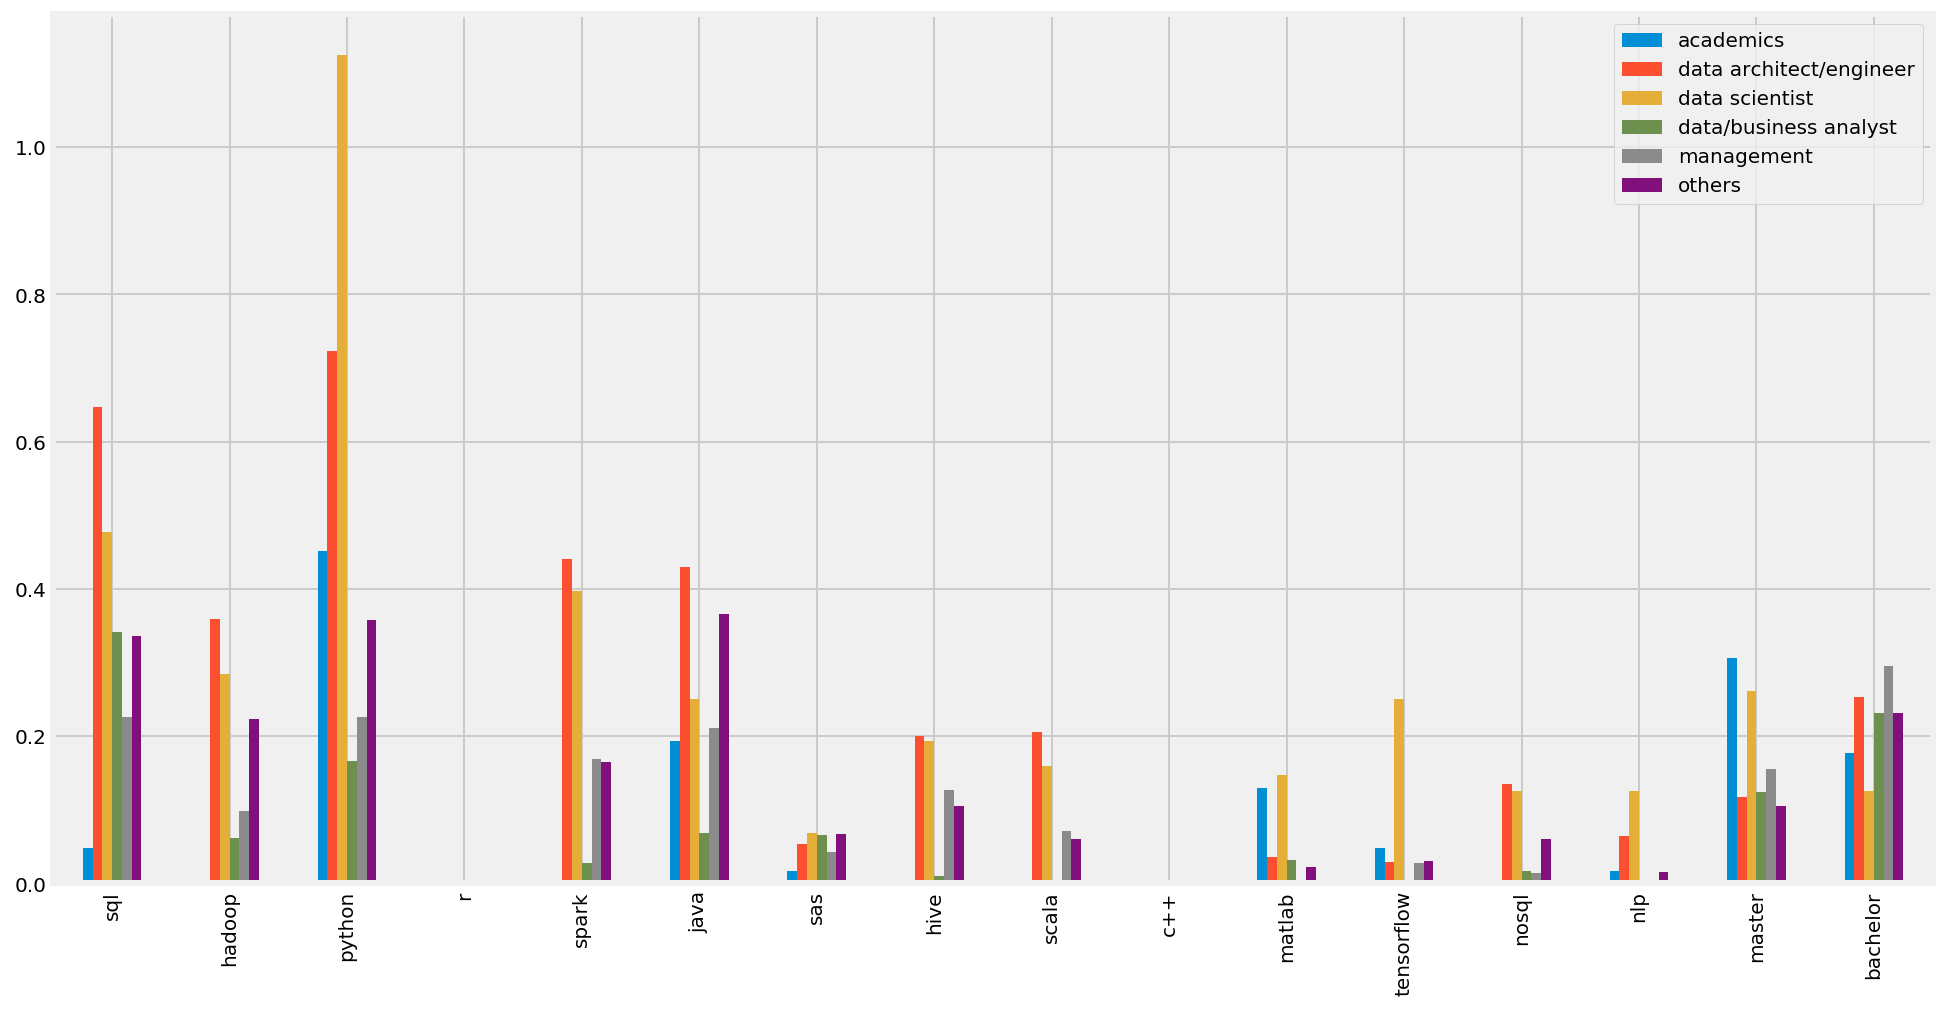

In [72]:
# Plot the dataframe created to visualize relationship between job titles and tf-idf value for different skills

skills_df.T.plot(kind='bar',figsize=(15,8));

As seen from the plot, there are some skills e.g. python and tensorflow that ranks especially highly for data scientists compared to other job titles. Hence, these skills keywords are likely important features for predicting job titles, and I will be using them as predictor variables.

At the same time, the CountVectorizer returned 0 counts of the skill 'r' and 'c++'. This is because the single alphabet 'r' is listed in the collection of stopwords under the sklearn library. Hence, it was automatically removed during the processing. 

In this case, I will not make a further effort to remove the character 'r' from the stopwords, as I have already identified enough skill keywords have vastly different counts among different job titles. 

## Set up the final predictor and target variables

In [89]:
# Add all the key phrases consolidated earlier to the vocab list with the skills keywords

vocab = ['sql','hadoop','python','r','spark','java','sas','hive','scala','c++','matlab','tensorflow',
         'nosql','nlp','master','bachelor']

for phrase in key_phrases:
    vocab.append(phrase)

In [90]:
# Rerun steps above to do CountVectorizer based on my chosen vocabulary and the top key phrases

In [91]:
# Fit CountVectorizer to tokenize the data
   # I played around with some of the parameters e.g. min_df and ngram_range. The hyperparameters used below 
   # are the most optimal ones that I had tried

# The top results consists of some irrelvant words that do not tell much, e.g. requirements, work, shortlisted, candidates
# Hence, I will add those words to stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)

stop = ['requirements','work','candidates','shortlisted','end','regret','notified','analyst','scientist']

for word in stop:
    stopwords.append(word)

cvt = CountVectorizer(min_df=0.05, ngram_range=(1,4), stop_words=stopwords, vocabulary=vocab)
cvt.fit(X_train['job_desc_req'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngram_range=(1, 4), preprocessor=None,
        stop_words=['rather', 'which', 'around', 'fifteen', 'though', 'were', 'thereupon', 'whom', 'have', 'five', 'being', 'enough', 'ours', 'third', 'within', 'interest', 'among', 'back', 'seem', 'with', 'another', 'put', 'into', 'whereas', 'but', 'am', 'him', 'somewhere', 'cant', 'three', 'was', 'can', '...irements', 'work', 'candidates', 'shortlisted', 'end', 'regret', 'notified', 'analyst', 'scientist'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=['sql', 'hadoop', 'python', 'r', 'spark', 'java', 'sas', 'hive', 'scala', 'c++', 'matlab', 'tensorflow', 'nosql', 'nlp', 'master', 'bachelor', 'communication skills', 'years experience', 'business analysis', 'business proces

In [92]:
# Perform the transformation on X_train

job_desc_req_words = cvt.transform(X_train['job_desc_req'])
columns = np.array(cvt.get_feature_names())

In [93]:
# Join the token count info back to the main DataFrame for X_train

    # Create separate Dataframe for CountVectorized info first
cvt_job = pd.DataFrame(job_desc_req_words.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_train.reset_index(drop = True, inplace = True) 
X_train = pd.concat([X_train,cvt_job],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_train = X_train.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [94]:
# Process X_test in the same way

 # Transform the text in X_test in the same steps, using the same parameters as X_train

job_desc_req_words = cvt.transform(X_test['job_desc_req'])

 # Create separate Dataframe for CountVectorized info first
cvt_job = pd.DataFrame(job_desc_req_words.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_test.reset_index(drop = True, inplace = True) 
X_test = pd.concat([X_test,cvt_job],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_test = X_test.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [95]:
# Get dummies for X_train and X_test
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [96]:
# Check if X_train and X_test have the same number of columns after transformation

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('Difference between X_train and X_test: ',set(X_train.columns)-set(X_test.columns))

X_train shape:  (815, 64)
X_test shape:  (144, 64)
Difference between X_train and X_test:  set()


In [97]:
# Standardize the features as there are many features on different scales e.g. salaries vs token counts

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


# Build a classification model to predict job title

### Start with a simple logistic regression model to check performance before tuning and exploring other models

In [98]:
# Build a simple logistic regression model for multinomial classification

logreg = LogisticRegression(multi_class='auto',solver='lbfgs',max_iter=10000)
scores = cross_val_score(logreg,X_train_std,y_train,cv=3)
print('Scores for cross validation:',scores)
print('Mean score:',np.mean(scores))
print('Standard Deviation of score:',np.std(scores))

Scores for cross validation: [0.50729927 0.54945055 0.52985075]
Mean score: 0.5288668552640664
Standard Deviation of score: 0.01722224568057056


In [99]:
# Fit the model to predict on the test data

logreg.fit(X_train_std,y_train)
y_pred = logreg.predict(X_test_std)
y_pred_proba = logreg.predict_proba(X_test_std)

print('Accuracy score:',accuracy_score(y_test,y_pred))
print('Recall score:',recall_score(y_test,y_pred, average='weighted'))
print('Precision score:',precision_score(y_test,y_pred, average='weighted'))

Accuracy score: 0.5069444444444444
Recall score: 0.5069444444444444
Precision score: 0.48453598285192206


In [100]:
# Check baseline for the multinomial classification
print(y_test.value_counts())
print(' ')
print('Baseline = ',51/np.sum(y_test.value_counts()))

data/business analyst      51
data architect/engineer    30
others                     23
data scientist             16
management                 13
academics                  11
Name: job_title_clean, dtype: int64
 
Baseline =  0.3541666666666667


Using a simple logistic regression model, the accuracy score obtained is better than the baseline. I will use the AUC score to further examine the performance of the model.

In [101]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

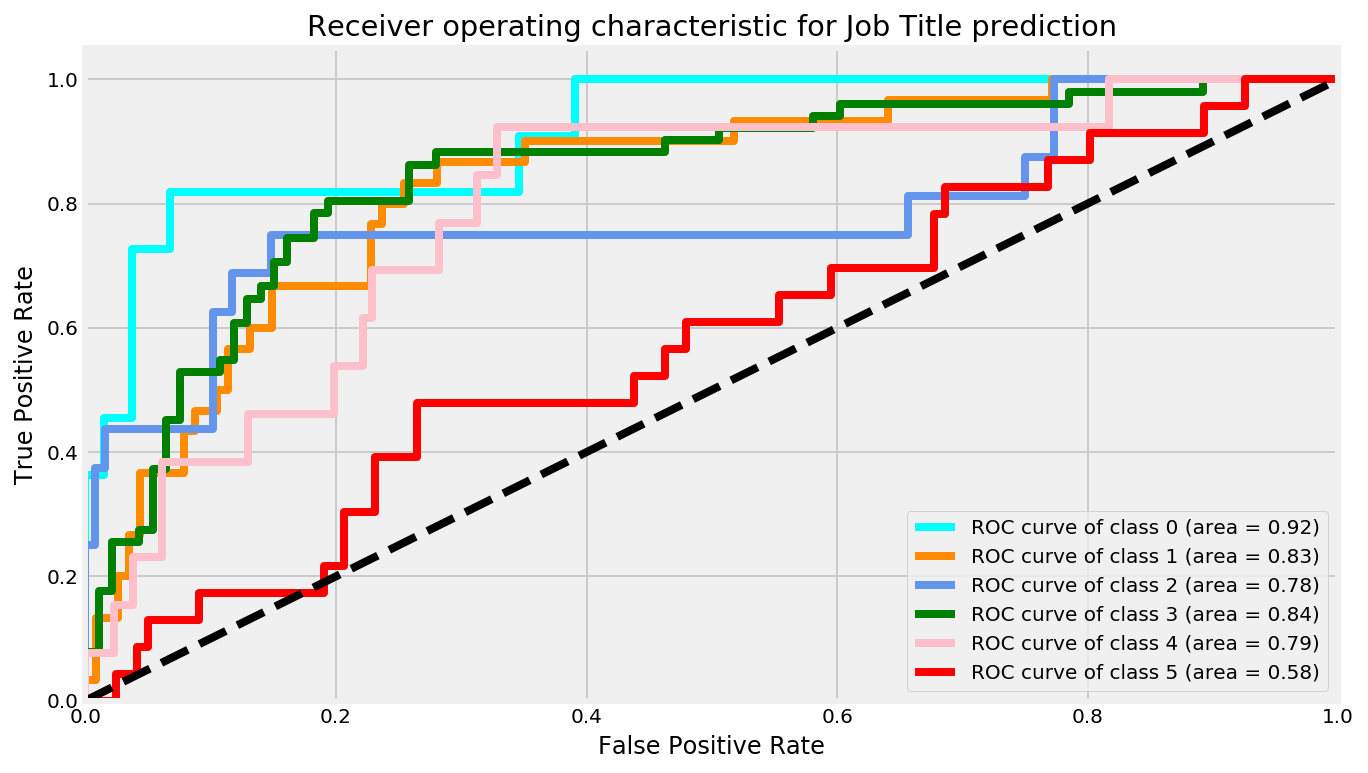

In [102]:
# Plot all ROC curves

n_classes = 6

plt.figure(figsize= (10,6))

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Job Title prediction')
plt.legend(loc="lower right")
plt.show()

In [103]:
# Print classification report to study the score for each job title

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              academics       0.50      0.45      0.48        11
data architect/engineer       0.55      0.57      0.56        30
         data scientist       0.41      0.44      0.42        16
  data/business analyst       0.63      0.75      0.68        51
             management       0.33      0.15      0.21        13
                 others       0.20      0.17      0.19        23

              micro avg       0.51      0.51      0.51       144
              macro avg       0.44      0.42      0.42       144
           weighted avg       0.48      0.51      0.49       144



In [104]:
# Compare the number of samples for the different classes vs the model performance for those clases

print(y_test.value_counts())

data/business analyst      51
data architect/engineer    30
others                     23
data scientist             16
management                 13
academics                  11
Name: job_title_clean, dtype: int64


The results were better for some classes (e.g. business/data analysts) and worse for the minority classes (e.g. others). This is likely due to effect of the imbalanced class problem. As there are fewer samples for the minority classes, the model does not do well in predicting such classes. 

To resolve the issue,I will conduct resampling to balance the different classes and re-run the model to test.

Based on the results of the basic logistic regression above, the scores are already better than the baseline. Hence, I will continue to tune the model and explore other models to make a better prediction.

### Resampling to resolve class imbalance 

In [105]:
# Resampling using SMOTE across a range of different k_neighbors to find the best k_neighbors value
    # I am iterating through a range of k to get the best auc score
        
logreg = LogisticRegression(solver='lbfgs',multi_class='auto', max_iter=10000)
        
for k in range(1,10,1):
    
    skf = StratifiedKFold(n_splits=3, random_state=2, shuffle=True)
    score= []

    for train_index, test_index in skf.split(X_train,y_train):
        X_train_cross, X_test_cross = X_train_std[train_index], X_train_std[test_index]
        y_train_cross, y_test_cross = y_train.iloc[train_index], y_train.iloc[test_index]
        
        sm = SMOTE(ratio='all',k_neighbors=k, random_state=240)
        X_smote, y_smote = sm.fit_sample(X_train_cross, y_train_cross)
        
        logreg.fit(X_smote, y_smote)
        y_pred_cross = logreg.predict(X_test_cross)
        
        accuracy = accuracy_score(y_test_cross, y_pred_cross)
        
        score.append(accuracy)

    print('k: ',k,'mean accuracy score: ', np.mean(score), 'std: ', np.std(score))

k:  1 mean accuracy score:  0.4968514224152094 std:  0.01913411650696403
k:  2 mean accuracy score:  0.49063301577191987 std:  0.017138745509961667
k:  3 mean accuracy score:  0.4981412620861363 std:  0.003960960713909475
k:  4 mean accuracy score:  0.4991844805277641 std:  0.026427150317791404
k:  5 mean accuracy score:  0.4992122154394733 std:  0.018049365151523788
k:  6 mean accuracy score:  0.48939319205688087 std:  0.02848915691793746
k:  7 mean accuracy score:  0.49313840279631765 std:  0.017631066355526515
k:  8 mean accuracy score:  0.5079137280629817 std:  0.013913799060216371
k:  9 mean accuracy score:  0.4918446057459022 std:  0.023465737585443115


Based on the scores above, k_neighbors=8 produces the best accuracy score. The difference in score for different k_neighbors does not differ too much, hence I will not tune this parameter again for other models anymore.

I will use k=8 to rebalance the train dataset. 

In [106]:
# Resample X_train and y_train based on k_neighbors=1

sm = SMOTE(ratio='all',k_neighbors=8, random_state=240)
X_smote, y_smote = sm.fit_sample(X_train_std, y_train)

In [107]:
# Check the dataset after rebalancing, to make sure all classes are balanced

pd.Series(y_smote).value_counts()

data architect/engineer    290
data/business analyst      290
academics                  290
others                     290
data scientist             290
management                 290
dtype: int64

As seen from the count results, the different classes have been balanced out. In particular, note that the class which had the smallest sample previously (i.e. others) was oversampled and had 279 samples added. 

As samples were created synthetically based on the k-neighbors value assigned, this could bring potential problems such as inaccuracies in the model results due to errors introduced during resampling. 

### Run the Logistic Regression Model again after resampling the different classes

In [108]:
# Run log regression with gridsearch model again

skf = StratifiedKFold(n_splits=3, random_state=10, shuffle=True)

logreg = LogisticRegression(solver='lbfgs',multi_class='auto', max_iter=10000)

for train_index, test_index in skf.split(X_train_std,y_train):
    X_cross_train, X_cross_test = X_train_std[train_index], X_train_std[test_index]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
    sm = SMOTE(ratio='all',k_neighbors=8, random_state=240)
    X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
    logreg.fit(X_smote, y_smote)
    y_pred = logreg.predict(X_cross_test)
    y_pred_proba = logreg.predict_proba(X_cross_test)

    print('Accuracy score: ',accuracy_score(y_cross_test, y_pred))
    print('Recall score: ',recall_score(y_cross_test, y_pred, average='macro'))
    print('Precision score: ',precision_score(y_cross_test, y_pred, average='macro'))
    print('     ')

Accuracy score:  0.4927007299270073
Recall score:  0.494763397612014
Precision score:  0.4881823970495344
     
Accuracy score:  0.5018315018315018
Recall score:  0.5059965613464875
Precision score:  0.46518099463360435
     
Accuracy score:  0.47761194029850745
Recall score:  0.4966532494034368
Precision score:  0.47277809254307696
     


In [109]:
# Fit the best log regression model on the resampled X_train and y_train (X_smote and y_smote)
# Predict y_test 

logreg.fit(X_smote, y_smote)

y_pred = logreg.predict(X_test_std)
y_pred_proba = logreg.predict_proba(X_test_std)

In [110]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

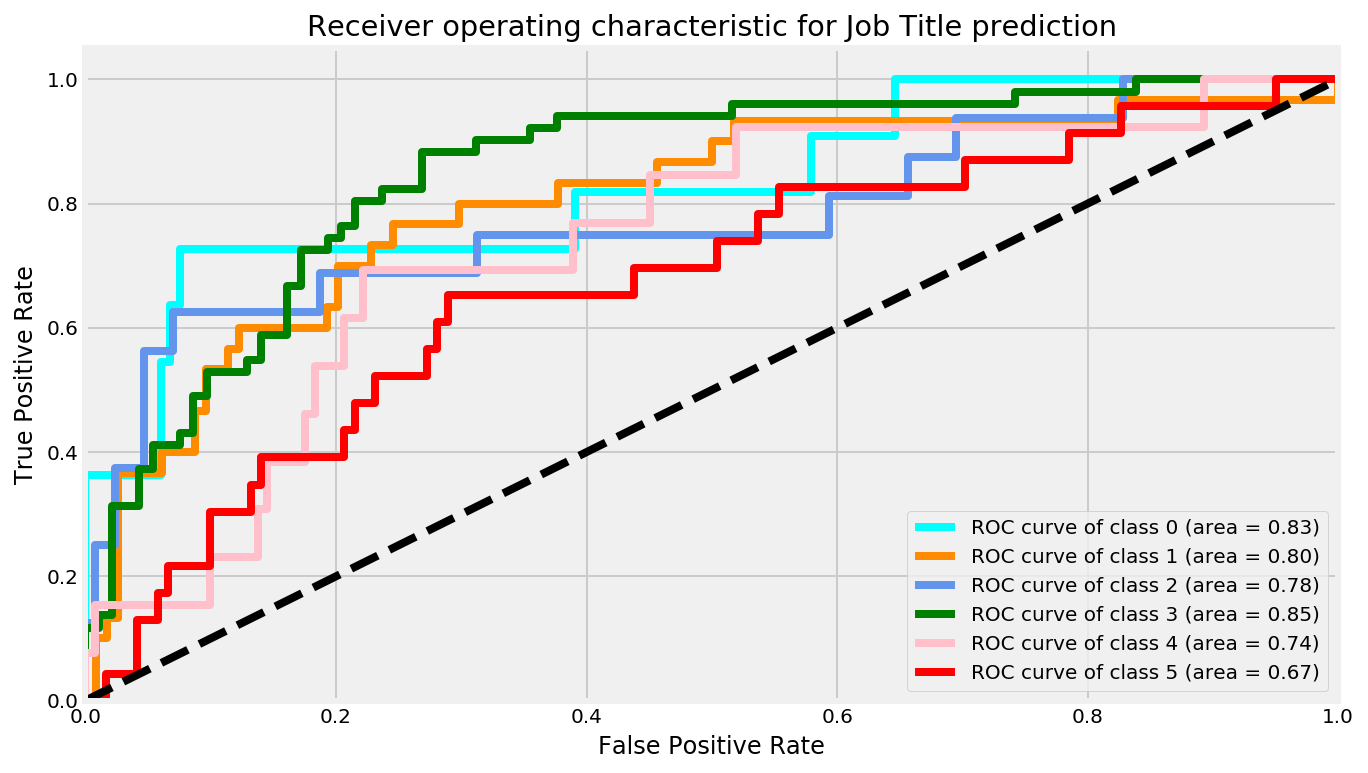

In [111]:
# Plot all ROC curves

n_classes = 6

plt.figure(figsize= (10,6))

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Job Title prediction')
plt.legend(loc="lower right")
plt.show()

In [112]:
# Print classification report to study the score for each job title

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              academics       0.36      0.36      0.36        11
data architect/engineer       0.49      0.60      0.54        30
         data scientist       0.50      0.56      0.53        16
  data/business analyst       0.74      0.55      0.63        51
             management       0.15      0.15      0.15        13
                 others       0.30      0.35      0.32        23

              micro avg       0.48      0.48      0.48       144
              macro avg       0.42      0.43      0.42       144
           weighted avg       0.51      0.48      0.49       144



While the accuracy score of the model remains approximately the same as before resampling, the AUC score for the class 'others' improved. On the other hand, the AUC scores of the other classes mostly dropped after resampling. This could be due to errors introduced during the resampling exercise when many samples were synthetically added. 

However, this model now performs better in general for nultiple classes. 

In [134]:
# Intepret the model
# Find the odds ratio based on the coefficients from logisitic regression model

log_coef = pd.DataFrame(np.exp(logreg.coef_), index= logreg.classes_, columns= list(X_train.columns))
log_coef

,sal_mid,sql,hadoop,python,r,spark,java,sas,hive,scala,...,master degree,science engineering,science related,information systems,hands experience,good knowledge,design develop,working experience,emp_type_clean_Internship,emp_type_clean_Permanent
academics,0.286692,0.166596,0.518140,0.591434,1.0,0.323138,1.365960,0.771183,0.775327,0.829851,...,0.950905,0.716808,1.404676,0.974973,0.643021,1.234590,0.555549,0.277477,0.831986,0.224854
data architect/engineer,0.906753,2.189553,1.593148,1.677613,1.0,1.551687,1.110335,0.855728,1.131163,1.241173,...,0.837943,0.971337,0.937038,0.818123,1.227100,1.642465,1.163877,1.207913,0.820679,1.119876
data scientist,1.321730,1.579082,0.609398,3.649714,1.0,4.336253,0.552385,0.649448,1.899984,0.966699,...,0.783424,1.309549,1.193758,0.637420,0.435638,0.313266,0.335054,0.972433,0.886555,0.815205
data/business analyst,0.893294,1.649221,2.546822,0.738488,1.0,0.960941,0.835392,1.417349,0.197090,0.858036,...,1.376428,1.104469,0.933736,1.188372,1.302577,1.044689,1.298197,1.388376,1.249242,0.975577
management,3.609493,0.856861,0.634525,0.525976,1.0,0.735219,0.786382,1.011394,2.163749,1.118513,...,0.838071,1.242837,0.670894,1.040650,1.560084,0.837275,1.856370,1.187405,0.996239,4.645451
others,0.902636,1.228531,1.230125,0.710940,1.0,0.650998,1.816945,1.627665,1.407240,1.046478,...,1.388727,0.798984,1.015951,1.590399,1.431588,1.799753,1.915364,1.861106,1.327380,1.074911


For each job title, the odds ratio for each feature differs. Hence, to intepret the model, we can study the odds ratio for the features for each job title to understand whether each feature is more likely to predict a certain class. 

At this point, I will also try other models first to check if they offer a better performance.

### Explore using the KNNClassifier

#### KNN Classifier model without rebalancing class

In [113]:
# Build a KNN Classififer model to predict the different classes, using different number of n_neighbors

from sklearn.neighbors import KNeighborsClassifier

for i in range(1,10,1):
    knn = KNeighborsClassifier(n_neighbors=i)
    print(i,cross_val_score(knn,X_train_std,y_train,cv=3))

1 [0.49270073 0.46886447 0.44029851]
2 [0.45985401 0.48351648 0.42164179]
3 [0.44160584 0.49084249 0.43283582]
4 [0.50364964 0.49084249 0.44776119]
5 [0.50729927 0.47985348 0.45149254]
6 [0.50364964 0.49450549 0.44402985]
7 [0.51094891 0.4981685  0.46268657]
8 [0.51459854 0.5018315  0.4738806 ]
9 [0.51459854 0.48717949 0.45149254]


In [114]:
# Set up a knn model and fit it to the X
    # Based on the best n_neighbor value of 8, as seen from the score in the previous cell

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
y_pred_proba = knn.predict_proba(X_test_std)

In [115]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

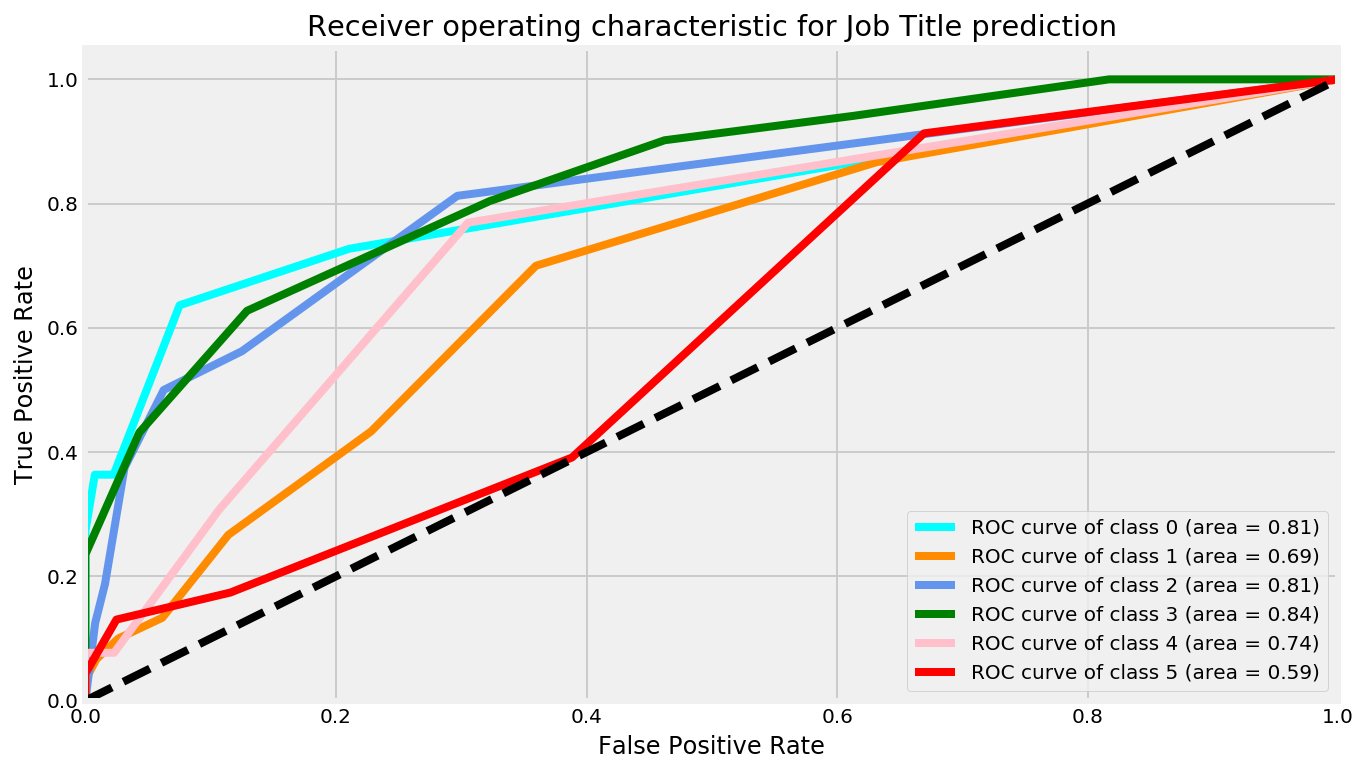

In [116]:
# Plot all ROC curves

n_classes = 6

plt.figure(figsize= (10,6))

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Job Title prediction')
plt.legend(loc="lower right")
plt.show()

In [117]:
# Print classification report to study the score for each job title

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              academics       0.44      0.36      0.40        11
data architect/engineer       0.34      0.40      0.37        30
         data scientist       0.58      0.44      0.50        16
  data/business analyst       0.55      0.86      0.67        51
             management       0.00      0.00      0.00        13
                 others       0.38      0.13      0.19        23

              micro avg       0.49      0.49      0.49       144
              macro avg       0.38      0.37      0.36       144
           weighted avg       0.42      0.49      0.43       144



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [118]:
# Check the value counts of each job title against the scores

y_test.value_counts()

data/business analyst      51
data architect/engineer    30
others                     23
data scientist             16
management                 13
academics                  11
Name: job_title_clean, dtype: int64

Based on the results above, the precision and recall scores for 'management' are especially low. This could be because it is a minority class in the original dataset. As it is under-represented, the predictions for this class may not be accurate. 

In particular, it is important to note the warning raised when running the model - "Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples." This again raises issues about the model, as the model does not perform well.

Given that the original dataset has imbalanced classes, I will try resampling using SMOTE as well for the KNN Classifier model.

In [119]:
# Build a KNN Classififer model to predict the different classes by fitting to the resampled dataset

from sklearn.neighbors import KNeighborsClassifier

score_list = []

for i in range(1,10,1):
    
    knn = KNeighborsClassifier(n_neighbors=i)
     
    skf = StratifiedKFold(n_splits=3, random_state=10, shuffle=True)
    
    accuracy_scores = []
    recall_scores = []
    precision_scores = []

    for train_index, test_index in skf.split(X_train,y_train):
        X_cross_train, X_cross_test = X_train_std[train_index], X_train_std[test_index]
        y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        sm = SMOTE(ratio='minority',k_neighbors=8, random_state=240)
        X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
        knn.fit(X_smote, y_smote)
        y_pred = knn.predict(X_cross_test)
        
        accuracy_scores.append(accuracy_score(y_cross_test, y_pred))
        recall_scores.append(recall_score(y_cross_test, y_pred, average='macro'))
        precision_scores.append(precision_score(y_cross_test, y_pred, average='macro'))
        
    score_list.append([i,np.mean(accuracy_scores),np.mean(recall_scores),np.mean(precision_scores)])

In [120]:
score_list
# Each list shows the number of k_neighbors, and the corresponding accuracy score, recall score and precision score
# Since 1 gives the best result, I will use k=1 to fit the KNN Classifier model and predict the test set

[[1, 0.4858629102555456, 0.44557877697820797, 0.44140443794979095],
 [2, 0.46761027886422807, 0.42904935084273726, 0.4374454587808166],
 [3, 0.44186822365273176, 0.4061440690241802, 0.4058020293508903],
 [4, 0.4541837216420504, 0.4122768316225304, 0.4128100573984943],
 [5, 0.4344644654591272, 0.38529382617665736, 0.3752633283612239],
 [6, 0.46514995275753535, 0.4185933172192493, 0.4440419517185143],
 [7, 0.4502562719144046, 0.4016812573006694, 0.4231900988896844],
 [8, 0.44785982921945444, 0.39206922547903816, 0.4298355734478483],
 [9, 0.4452999700303328, 0.39288562162969454, 0.4323182382207838]]

In [121]:
# Fit the knn model on the resampled data to predict the test data

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_smote, y_smote)
y_pred = knn.predict(X_test_std)
y_pred_proba = knn.predict_proba(X_test_std)

In [122]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

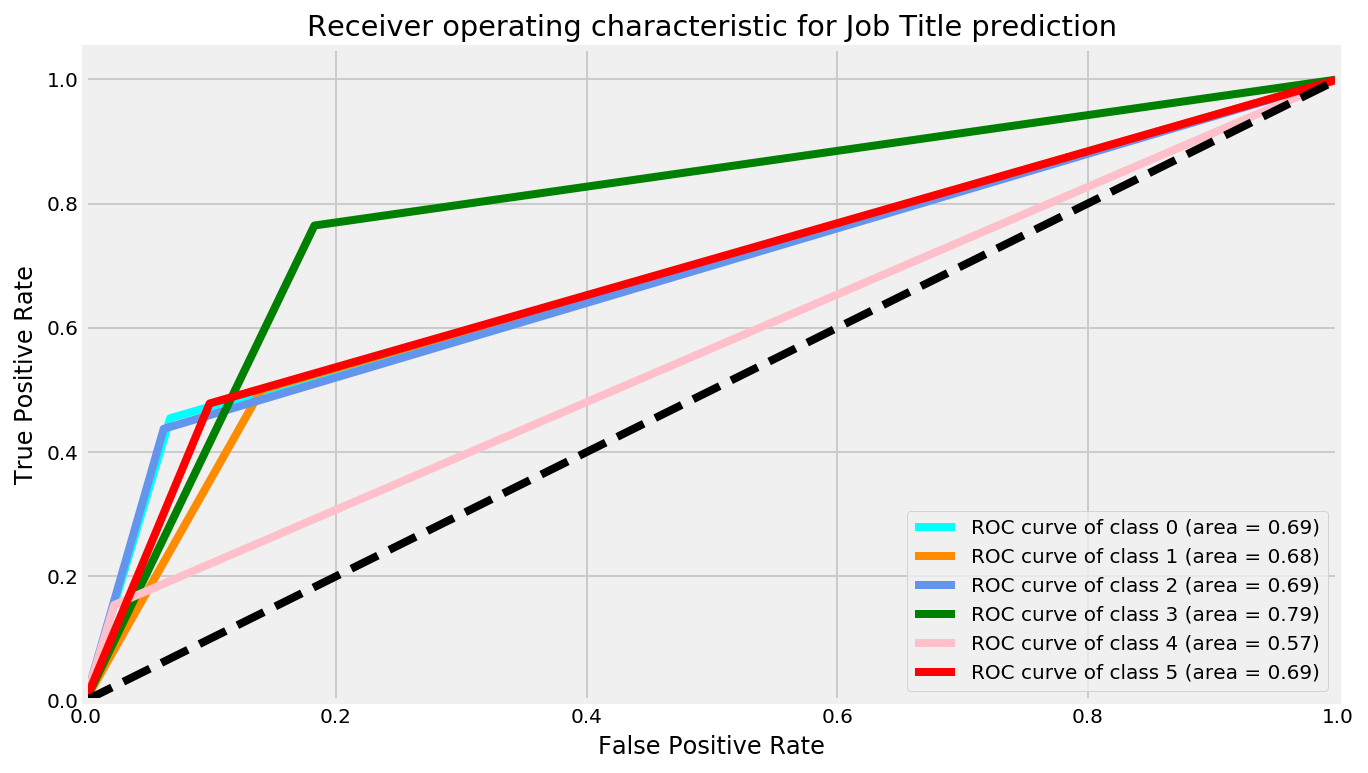

In [123]:
# Plot all ROC curves

n_classes = 6

plt.figure(figsize= (10,6))

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Job Title prediction')
plt.legend(loc="lower right")
plt.show()

In [124]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              academics       0.36      0.45      0.40        11
data architect/engineer       0.48      0.50      0.49        30
         data scientist       0.47      0.44      0.45        16
  data/business analyst       0.70      0.76      0.73        51
             management       0.40      0.15      0.22        13
                 others       0.48      0.48      0.48        23

              micro avg       0.55      0.55      0.55       144
              macro avg       0.48      0.46      0.46       144
           weighted avg       0.54      0.55      0.54       144



As expected, the AUC score for the minority classes improved. However,the AUC scores in general for all classes are low at around 0.7. At this point, the logistic regression performs better than the KNN Classifier. 

I will continue to explore using Random Forest Classifier. 

## Build a Random Forest Classifier Model

In [125]:
# Build a basic random forest classifier model 

rfc = RandomForestClassifier(n_jobs=-1)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=2, shuffle=True)

for train_index, test_index in skf.split(X_train,y_train):
    X_cross_train, X_cross_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
    sm = SMOTE(ratio='all',k_neighbors=8, random_state=240)
    X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
    rfc.fit(X_smote, y_smote)
    y_pred = rfc.predict(X_cross_test)
    y_pred_proba = rfc.predict_proba(X_cross_test)
        
    score = accuracy_score(y_cross_test,y_pred)

    print('The accuracy score for one fold is ',score)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy score for one fold is  0.551094890510949
The accuracy score for one fold is  0.5567765567765568
The accuracy score for one fold is  0.5447761194029851


In [126]:
# Fit a random forest classifier model on the resampled data to predict the test data

rfc.fit(X_smote,y_smote)
y_pred = rfc.predict(X_test_std)
y_pred_proba = rfc.predict_proba(X_test_std)

In [127]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

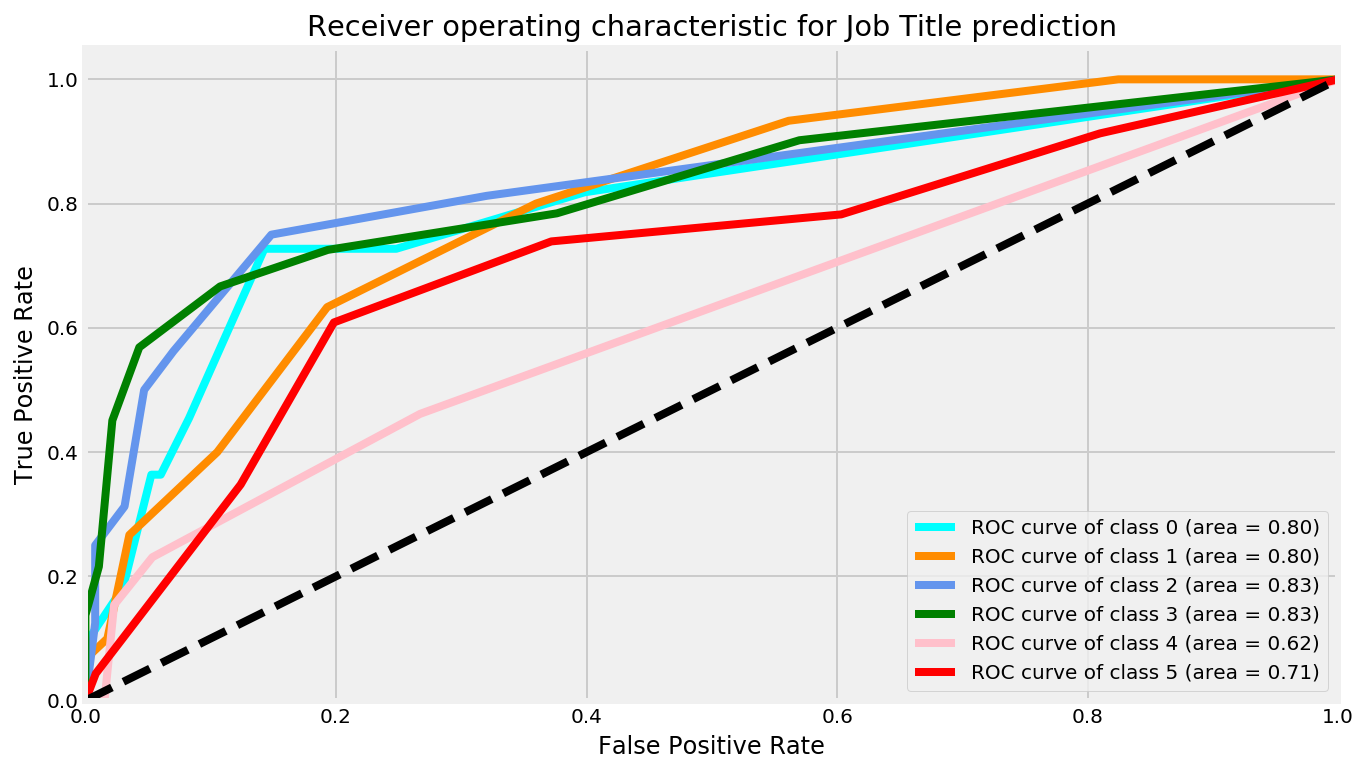

In [128]:
# Plot all ROC curves

n_classes = 6

plt.figure(figsize= (10,6))

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Job Title prediction')
plt.legend(loc="lower right")
plt.show()

In [129]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              academics       0.30      0.55      0.39        11
data architect/engineer       0.47      0.60      0.53        30
         data scientist       0.62      0.50      0.55        16
  data/business analyst       0.75      0.65      0.69        51
             management       0.00      0.00      0.00        13
                 others       0.36      0.43      0.39        23

              micro avg       0.52      0.52      0.52       144
              macro avg       0.42      0.45      0.43       144
           weighted avg       0.51      0.52      0.51       144



The random forest model produces better AUC scores for the features. However, on a closer look, the precision and recall scores for the class 'management' is 0. This likely means that there were no True Positives predicted for this clas. 

In that case, I should not use the random forest classifer for predictions. 

The best model so far is still the logistic regression model. Hence, I will proceed to intepret the coefficients of the model in detail now. 

In [143]:
# Intepret the model
# Find the odds ratio based on the coefficients from logisitic regression model

log_coef = pd.DataFrame(np.exp(logreg.coef_), index= logreg.classes_, columns= list(X_train.columns))
log_coef

,sal_mid,sql,hadoop,python,r,spark,java,sas,hive,scala,...,master degree,science engineering,science related,information systems,hands experience,good knowledge,design develop,working experience,emp_type_clean_Internship,emp_type_clean_Permanent
academics,0.286692,0.166596,0.518140,0.591434,1.0,0.323138,1.365960,0.771183,0.775327,0.829851,...,0.950905,0.716808,1.404676,0.974973,0.643021,1.234590,0.555549,0.277477,0.831986,0.224854
data architect/engineer,0.906753,2.189553,1.593148,1.677613,1.0,1.551687,1.110335,0.855728,1.131163,1.241173,...,0.837943,0.971337,0.937038,0.818123,1.227100,1.642465,1.163877,1.207913,0.820679,1.119876
data scientist,1.321730,1.579082,0.609398,3.649714,1.0,4.336253,0.552385,0.649448,1.899984,0.966699,...,0.783424,1.309549,1.193758,0.637420,0.435638,0.313266,0.335054,0.972433,0.886555,0.815205
data/business analyst,0.893294,1.649221,2.546822,0.738488,1.0,0.960941,0.835392,1.417349,0.197090,0.858036,...,1.376428,1.104469,0.933736,1.188372,1.302577,1.044689,1.298197,1.388376,1.249242,0.975577
management,3.609493,0.856861,0.634525,0.525976,1.0,0.735219,0.786382,1.011394,2.163749,1.118513,...,0.838071,1.242837,0.670894,1.040650,1.560084,0.837275,1.856370,1.187405,0.996239,4.645451
others,0.902636,1.228531,1.230125,0.710940,1.0,0.650998,1.816945,1.627665,1.407240,1.046478,...,1.388727,0.798984,1.015951,1.590399,1.431588,1.799753,1.915364,1.861106,1.327380,1.074911


In [147]:
# Top features of data scientist

log_coef.T['data scientist'].sort_values(ascending=False)[:10]

deep learning              6.051769
spark                      4.336253
python                     3.649714
big data analytics         2.564390
data mining                2.376592
experience data            2.308151
hive                       1.899984
tensorflow                 1.862071
degree computer science    1.793364
data analytics             1.683969
Name: data scientist, dtype: float64

In [148]:
# Top features of data architect / engineer

log_coef.T['data architect/engineer'].sort_values(ascending=False)[:10]

sql                     2.189553
software engineering    2.129737
best practices          1.973692
degree computer         1.949339
edu sg                  1.940907
business process        1.721392
python                  1.677613
team members            1.670202
experience data         1.658629
good knowledge          1.642465
Name: data architect/engineer, dtype: float64

In [149]:
# Top features of data/business analyst

log_coef.T['data/business analyst'].sort_values(ascending=False)[:10]

hadoop                     2.546822
business analysis          2.463703
bachelor degree            1.943632
matlab                     1.914304
business processes         1.768154
user acceptance            1.767290
artificial intelligence    1.672382
data science               1.653732
sql                        1.649221
experience business        1.643322
Name: data/business analyst, dtype: float64

In [150]:
# Top features of academics

log_coef.T['academics'].sort_values(ascending=False)[:10]

machine learning     11.330892
computer science      2.997525
big data              2.495741
management skills     2.468456
edu sg                2.251684
data sets             2.005674
deep learning         1.576874
open source           1.569052
science related       1.404676
skills ability        1.371507
Name: academics, dtype: float64

In [151]:
# Top features of management

log_coef.T['management'].sort_values(ascending=False)[:10]

emp_type_clean_Permanent    4.645451
sal_mid                     3.609493
bachelor degree             2.542613
hive                        2.163749
design develop              1.856370
skills ability              1.838503
project management          1.825604
big data analytics          1.698344
master                      1.606875
data analytics              1.568877
Name: management, dtype: float64

In [152]:
# Top features of others

log_coef.T['others'].sort_values(ascending=False)[:10]

business analysis       2.380323
tensorflow              2.141337
edu sg                  2.131334
design develop          1.915364
working experience      1.861106
java                    1.816945
good knowledge          1.799753
big data                1.680943
software engineering    1.640198
sas                     1.627665
Name: others, dtype: float64

<font color = 'purple'>
    
# Executive Summary

________

__Methodology__

In this study, I performed exploratory data analysis to identify plausible relationships between job titles and various features e.g. salary amount, seniority level, industries etc. NLP techniques were also used for feature engineering to create features consisting of keywords in job decription and requirements for different job titles. 

Using classification models e.g. Logistic Regression, K Nearest Neighbors and Random Forest Classifier, I studied the accuracy, precision and recall scores and the AUC score to determine the best model. In addition, I looked out for intepretability of the classification models to draw meaning from the results. 


__Findings__

Most of the job titles have different defining features e.g. the presence of deep learning in the job description increases the likelihood of the position being a data scientist, while a permanent employment type increases the likelihood of the position being a management.

Resampling improves the overall performance of the model for the minority classes, hence in general is more appropriate than a model without resampling. 

It is difficult to obtain a single good model for multiclass classification. Possible methods for improvement may be through ensemble models e.g. bagging / aggregating the results from various models to obtain a more accurate prediction since each model is not able to give a highly accurate prediction in this cas. 


__Limitations__

The resampling was significant, with the minority class resampled from 11 to 290. This very likely introduced inaccuracies during the resampling process, as the new samples are synthethically created based on the assigned n_neighbors value.

To improve on the results, a better way would have been to work with larger sample sizes by:
 - Web scraping more websites for additional job listings
 - Collect the data over a longer duration of time to collect more job listings as well

This study identifies the features which likely defines different job titles. However, there would be limited usage for this model in the business context as the information provides minimal commercial value. 

It would be more useful to study factors that affect attractiveness of a job listing e.g. salary amount, company location, industry etc. versus the number of applicants (this data is also available on job search websites). In this way, recruitment companies will be able to use the model to create the most attractive job listings to draw talents in the data science field where talents are in short supply. 